In [1]:
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# Define the parameters of the system

w       = 1
deff    = 1
n2w     = 1
c       = 1
Ew      = 1

dk_max  = 2e0
z_max   = 1.2e1
z_int   = 1.1e1

alpha   = w * deff * Ew**2 / (n2w * c)
alpha_teo = 1e-1

# Define the parameters of the neural network

n_input     = 2
n_output    = 2
n_hidden    = 200

In [4]:
# For testing purposes, we define the solution of the EDP

def sol(dk, index=None):
    E = -1J * alpha_teo * z_int * np.sin(dk * z_int / 2) / (dk * z_int / 2) * np.exp(1J * (dk * z_int / 2))

    if index == 'real':
        return np.real(E)
    elif index == 'imag':
        return np.imag(E)
    else:
        return np.abs(E)
    
def sol_torch(dk, index=None):
    E = -1J * alpha_teo * z_int * torch.sin(dk * z_int / 2) / (dk * z_int / 2) * torch.exp(1J * (dk * z_int / 2))

    if index == 'real':
        return torch.real(E)
    elif index == 'imag':
        return torch.imag(E)
    else:
        return torch.abs(E)

N_integral  = 1000
dx          = 2*dk_max/N_integral
intensity   = dx*np.sum(sol(np.linspace(-dk_max, dk_max, N_integral))**2)

In [5]:
class Second_harmonic(nn.Module):
    # Defines the Neural Network that we're going to use for train our solution
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        self.input        = nn.Linear(n_input, n_hidden)          # Define the input later for our NN
        self.hidden       = nn.Linear(n_hidden, n_hidden)         # Defines hidden layers for our NN 
        self.output      = nn.Linear(n_hidden, n_output)         # Define the output layer the NN

    def forward(self, x, y):
        n_layer = 4
        inputs  = torch.cat([x, y], axis = 1)

        input  = self.input(inputs)
        input  = torch.sin(input)
        
        for i in range(n_layer):
            input = self.hidden(input)
            input = torch.sin(input)

        outputs    = self.output(input)
        
        return outputs

In [6]:
# Create the neural network with the parameters defined before

PINN    = Second_harmonic(n_input, n_output, n_hidden)
PINN    = PINN.to(device)

In [7]:
# Define the elements required for train the neural network

def randpoint(dk):
    x = 2*dk*random.random()-dk

    return np.round(x, 4)

# Define the variable to be estimated

alpha = torch.nn.Parameter(torch.zeros(1).to(device))

# Define hyper-parameters

N_bound     = 1000
N_domain    = 200
N_train     = 50001
N_data      = 20
N_integral  = 500

optimizer   = torch.optim.Adam(list(PINN.parameters()) + [alpha], lr=1e-3)
loss_values = []
alpha_vals  = []

# Create the grid for domain

dk_domain   = torch.linspace(-dk_max, dk_max, N_domain, device=device)
z_domain    = torch.linspace(0, z_max, N_domain, device=device)

dk_domain, z_domain = torch.meshgrid(dk_domain, z_domain, indexing='ij')

dk_domain   = dk_domain.reshape(-1, 1).requires_grad_(True)
z_domain    = z_domain.reshape(-1, 1).requires_grad_(True)

# Now, we create the grid for the boundary condition

dk_bound    = torch.linspace(-dk_max, dk_max, N_bound, device=device).reshape(-1, 1)
z_bound     = torch.zeros_like(dk_bound, device=device)

# We create the domain for the integral

dk_integral = torch.linspace(-dk_max, dk_max, N_integral, device=device).reshape(-1, 1)
z_integral  = z_int*torch.ones_like(dk_integral, device=device)

# We create data for train the NN

dk_data     = torch.tensor([randpoint(dk_max) for i in range(N_data)]).reshape(-1, 1).to(device=device).to(dtype=torch.float32)
z_data      = z_int*torch.ones_like(dk_data, device=device)

# Consider the phase matching condition

dk_pm       = torch.tensor([0]).to(device=device).reshape(-1, 1).to(dtype=torch.float32)
z_pm        = z_int*torch.ones_like(dk_pm, device=device)

In [8]:
# Train our model

# Define the weights for the loss function

w1  = 1e1
w2  = 1e1
w3  = 0
w4  = 1e2
w5  = 1e2

for train_iter in range(N_train):
    optimizer.zero_grad()

    # Compute all the derivatives functions for implement the EDP
    E       = PINN(dk_domain, z_domain)

    dEdz_r  = torch.autograd.grad(E[:, 0], z_domain, torch.ones_like(E[:, 0]), create_graph=True)[0]
    dEdz_i  = torch.autograd.grad(E[:, 1], z_domain, torch.ones_like(E[:, 1]), create_graph=True)[0]

    eq_r    = dEdz_r - alpha * torch.sin(dk_domain * z_domain)
    eq_i    = dEdz_i + alpha * torch.cos(dk_domain * z_domain)
    ls_edp  = torch.sum((eq_r)**2) + torch.sum((eq_i)**2)

    # Introduce the constraint related with the boundary condition
    E_bound = PINN(dk_bound, z_bound)
    
    ls_bc   = torch.sum((E_bound)**2)

    # Create a loss funcion part related with the integral data
    E_pred  = PINN(dk_integral, z_integral)
    
    E_r     = E_pred[:, 0]
    E_i     = E_pred[:, 1]
    E_norm  = dx*torch.sum(E_r**2 + E_i**2)

    ls_int  = torch.abs((intensity - E_norm)**2)

    # Create the loss function part related with experimental data points

    E_data  = PINN(dk_data, z_data)

    E_sol_r = sol_torch(dk_data, index='real')
    E_sol_i = sol_torch(dk_data, index='imag')
    E_sol   = torch.column_stack((E_sol_r, E_sol_i))

    ls_data = torch.sum((E_data - E_sol)**2)

    # The phase matching condition

    E_pm    = PINN(dk_pm, z_pm)
    E_sol   = sol_torch(dk_pm + 1e-4, z_pm)

    E_r     = E_pm[:, 0]
    E_i     = E_pm[:, 1]
    E_norm  = torch.sum(E_r**2 + E_i**2)

    ls_pm   = torch.abs((E_norm - E_sol)**2)

    # Then, we joint together every part of the loss function 

    loss    = w1 * ls_edp + w2 * ls_bc + w3 * ls_int + w4 * ls_data + w5 * ls_pm

    # Start the train updating the weights of the neural networks

    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    alpha_vals.append(alpha.item())

    if train_iter % 10000 == 0:
        print('iteration '+str(train_iter)+' complete with loss =', [loss.item(), w1 * ls_edp.item() , w2 * ls_bc.item() , w3 * ls_int.item(), w4 * ls_data.item(), w5*ls_pm.item(), alpha.item()])

iteration 0 complete with loss = [720.1441040039062, 174.0993881225586, 172.66735076904297, 0.0, 255.75039386749268, 117.62696504592896, -0.0009999998146668077]
iteration 10000 complete with loss = [0.5608310103416443, 0.3224349766969681, 0.18410202115774155, 0.0, 0.05140225403010845, 0.0028917840609210543, 0.09748525172472]
iteration 20000 complete with loss = [0.26558852195739746, 0.22533193230628967, 0.014080454129725695, 0.0, 0.019115390023216605, 0.0070607457018923014, 0.09775454550981522]
iteration 30000 complete with loss = [0.24903316795825958, 0.202791728079319, 0.021015885286033154, 0.0, 0.012781078112311661, 0.012444486492313445, 0.09770304709672928]
iteration 40000 complete with loss = [1.277308464050293, 1.233808845281601, 0.010127753484994173, 0.0, 0.030185875948518515, 0.003185970854246989, 0.09815419465303421]


KeyboardInterrupt: 

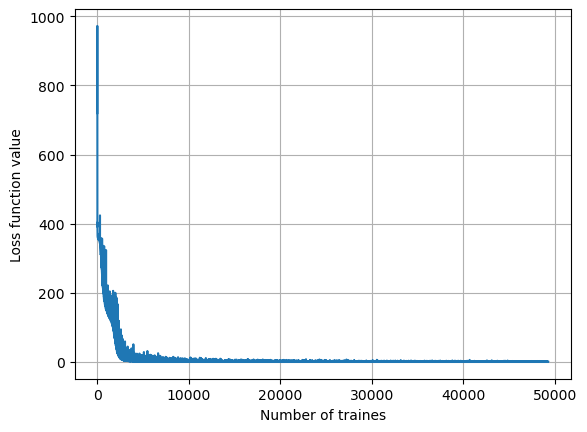

In [9]:
plt.plot(range(len(loss_values)), loss_values)
plt.grid()
plt.xlabel('Number of traines')
plt.ylabel('Loss function value')
# plt.ylim([0,10])

plt.show()

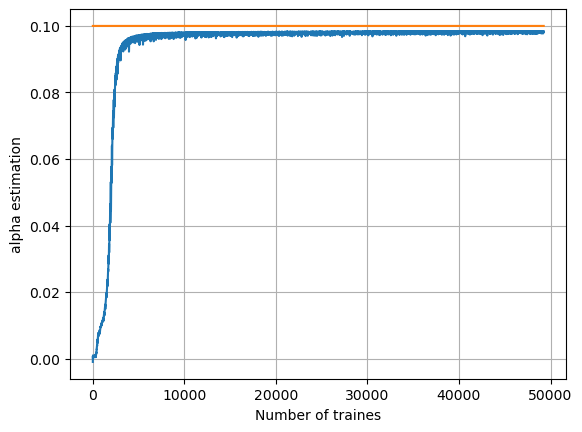

In [10]:
plt.plot(range(len(alpha_vals)), alpha_vals)
plt.plot(range(len(alpha_vals)), alpha_teo*np.ones_like(range(len(alpha_vals))))
plt.grid()
plt.xlabel('Number of traines')
plt.ylabel('alpha estimation')
# plt.ylim([0,10])

plt.show()

In [11]:
# Plot the results

dk  = torch.linspace(-dk_max, dk_max, 10*N_domain, device=device).reshape(-1, 1)
z   = z_max * torch.ones_like(dk)

E   = PINN(dk, z)
E_r = E[:, 0]
E_i = E[:, 1]

E_r = E_r.to('cpu')
E_i = E_i.to('cpu')

E_r = E_r.detach().numpy()
E_i = E_i.detach().numpy()

E   = np.sqrt(E_r**2 + E_i**2)

dk  = dk.to('cpu')
dk  = dk.detach().numpy()

dk_data = dk_data.to('cpu')
dk_data = dk_data.detach().numpy()

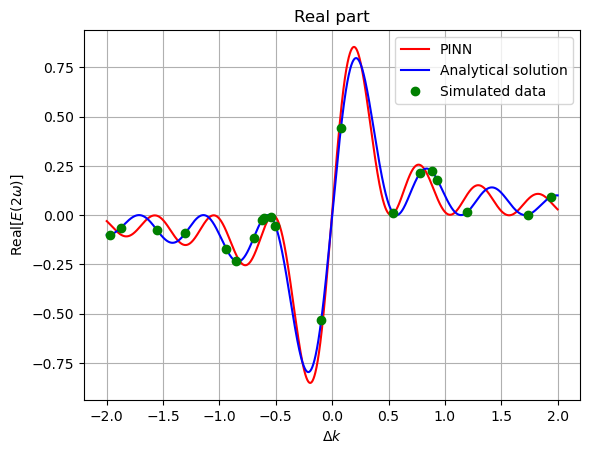

In [12]:
plt.clf()
plt.plot(dk, E_r, color='red', label='PINN')
plt.plot(dk, sol(dk, index='real'), color='blue', label='Analytical solution')
plt.plot(dk_data, sol(dk_data, index='real'), 'o', color='green', label='Simulated data')
plt.grid()
plt.title('Real part')
plt.xlabel(r'$\Delta k$')
plt.ylabel(r'$\mathrm{Real}[E(2 \omega)]$')
plt.legend(loc=0)

plt.show()

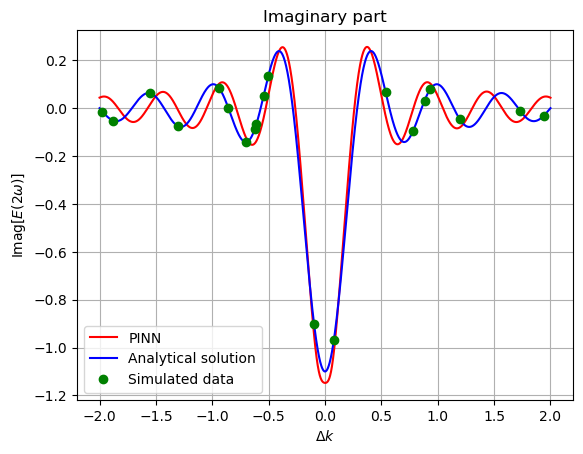

In [13]:
plt.clf()
plt.plot(dk, E_i, color='red', label='PINN')
plt.plot(dk, sol(dk, index='imag'), color='blue', label='Analytical solution')
plt.plot(dk_data, sol(dk_data, index='imag'), 'o', color='green', label='Simulated data')
plt.grid()
plt.title('Imaginary part')
plt.xlabel(r'$\Delta k$')
plt.ylabel(r'$\mathrm{Imag}[E(2 \omega)]$')
plt.legend(loc=0)

plt.show()

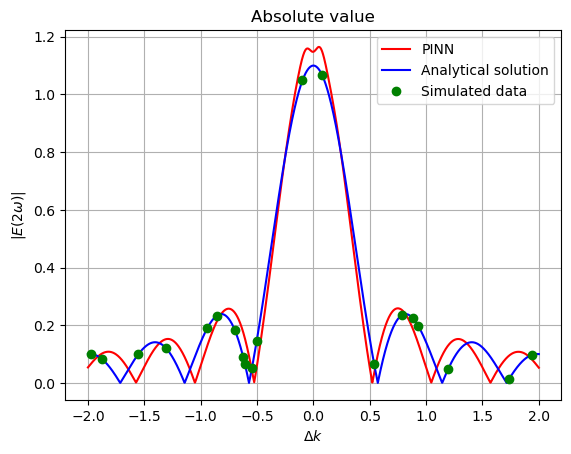

In [14]:
plt.clf()
plt.plot(dk, E, color='red', label='PINN')
plt.plot(dk, sol(dk), color='blue', label='Analytical solution')
plt.plot(dk_data, sol(dk_data), 'o', color='green', label='Simulated data')
plt.grid()
plt.title('Absolute value')
plt.xlabel(r'$\Delta k$')
plt.ylabel(r'$|E(2 \omega)|$')
plt.legend(loc=0)

plt.show()

In [15]:
# Save the model (run this cell to save the model)

# torch.save(PINN.state_dict(), 'checkpoint.pth')

In [16]:
# Load the model (run this cell if you previously saved a trained model)

# trained_model = torch.load('checkpoint.pth', map_location=torch.device('cpu'))

# PINN.load_state_dict(trained_model)

In [17]:
# Compute the acumulative error for the estimation

Error = np.abs(E - sol(dk).reshape(1, -1))
Error = np.sum(Error)/np.sum(np.abs(sol(dk)))*100

print('The estimation for the absolute field is ' + str(np.round(Error, 3)) + '% precise')

The estimation for the absolute field is 19.56% precise


In [18]:
Error = np.abs(E_r - sol(dk, index='real').reshape(1, -1))
Error = np.sum(Error)/np.sum(np.abs(sol(dk)))*100

print('The estimation for the real part field is ' + str(np.round(Error, 3)) + '% precise')

The estimation for the real part field is 22.071% precise


In [19]:
Error = np.abs(E_i - sol(dk, index='imag').reshape(1, -1))
Error = np.sum(Error)/np.sum(np.abs(sol(dk)))*100

print('The estimation for the imaginary part field is ' + str(np.round(Error, 3)) + '% precise')

The estimation for the imaginary part field is 22.422% precise


In [20]:
Error = np.abs(alpha_teo - alpha_vals[-1])/alpha_teo*100

print('The estimation for the alpha value is ' + str(np.round(Error, 3)) + '% precise')

The estimation for the alpha value is 1.801% precise
